# Problem Definition

The goal is to project sales for each department within 45 Walmart stores across different regions. This involves predicting the impact of selected holiday markdown events on sales within each department.

#### Goals

- Project sales accurately for each department in all 45 Walmart stores.
- Identify and quantify the impact of holiday markdown events on departmental sales.
- Provide actionable insights to optimize inventory management and marketing strategies based on predicted sales patterns.

#### Data Sources

Data Source: The dataset is sourced from Kaggle, a platform for data science competitions and datasets. https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast/data

- Historical sales data: Contains records of weekly sales across stores.
- Holiday markdown events data: Specifies the timing and magnitude of markdown events known to affect sales.
- Store-specific data: Includes information about each store's size and type.
- Environment-specific data: Includes information about the enviorment of each store like Temperature, Fuel Price, CPI, unemployment rate and more relevant data

## Evaluation

This project is evaluated on the weighted mean absolute error (WMAE):

WMAE=(1/∑wi)*∑wi|yi−y^i|
where


\\( \hat{y}_i \\) is the predicted sales

\\( y_i \\) is the actual sales

\\( w_i \\) are weights. w = 5 if the week is a holiday week, 1 otherwise

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import seaborn as sns

In [2]:
from scipy import stats

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

In [7]:
# Models

from sklearn.linear_model import LinearRegression
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn import linear_model, ensemble
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


C:\Users\hp\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [8]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [9]:
# Set default title fontsize
mpl.rcParams['axes.titlesize'] = 20

# Data Loading

In [10]:
df = pd.read_csv(r"C:\Users\hp\Desktop\Personal Projects\TSSF Walmart\train.csv")

test = pd.read_csv(r"C:\Users\hp\Desktop\Personal Projects\TSSF Walmart\test.csv")

store = pd.read_csv(r"C:\Users\hp\Desktop\Personal Projects\TSSF Walmart\stores.csv")

features = pd.read_csv(r"C:\Users\hp\Desktop\Personal Projects\TSSF Walmart\features.csv")

In [11]:
display(df)
display(test)
display(store)
display(features)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


# Data Cleaning: Step 1

##### Data cleaning documentation

- Change 'date' column data type from object to datetime
- Merged Train table with store & features table
- Merged Test table with store & features
- Missing values found at MarkDown1,2,3,4 (NOT handled yet)
- No duplicates found
- Added basic datetime features to train dataset


#### Cleaning

In [12]:
display(df.info())
display(features.info())
display(store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

In [13]:
# Fixing data type of Date column to date time format

df['Date'] = pd.to_datetime(df['Date'])
features['Date'] = pd.to_datetime(features['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [14]:
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].dt.week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [15]:
test['Day'] = test['Date'].dt.day
test['Week'] = test['Date'].dt.week
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [16]:
df['Date'].nunique()

143

In [17]:
features['Date'].nunique()

182

In [18]:
test['Date'].nunique()

39

In [19]:
# Merging df with store dataframe

df = pd.merge(df, store, on=['Store'])
test = pd.merge(test, store, on=['Store'])

In [20]:
df = pd.merge(df, features, on=['Store', 'Date'])
test = pd.merge(test, features, on=['Store', 'Date'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Day           421570 non-null  int64         
 6   Week          421570 non-null  int64         
 7   Month         421570 non-null  int64         
 8   Year          421570 non-null  int64         
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
 11  Temperature   421570 non-null  float64       
 12  Fuel_Price    421570 non-null  float64       
 13  MarkDown1     150681 non-null  float64       
 14  MarkDown2     111248 non-null  float64       
 15  MarkDown3     137

In [22]:
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [23]:
df.drop(columns=['IsHoliday_y'], inplace=True)

In [24]:
# Insert the column at the last position

temp = df.pop('Weekly_Sales')
df['Weekly_Sales'] = temp

In [25]:
df.shape

(421570, 20)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   IsHoliday     421570 non-null  bool          
 4   Day           421570 non-null  int64         
 5   Week          421570 non-null  int64         
 6   Month         421570 non-null  int64         
 7   Year          421570 non-null  int64         
 8   Type          421570 non-null  object        
 9   Size          421570 non-null  int64         
 10  Temperature   421570 non-null  float64       
 11  Fuel_Price    421570 non-null  float64       
 12  MarkDown1     150681 non-null  float64       
 13  MarkDown2     111248 non-null  float64       
 14  MarkDown3     137091 non-null  float64       
 15  MarkDown4     134

In [27]:
# Checking for any Nulls

df.isnull().sum()

Store                0
Dept                 0
Date                 0
IsHoliday            0
Day                  0
Week                 0
Month                0
Year                 0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Weekly_Sales         0
dtype: int64

In [28]:
test.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday_x         0
Day                 0
Week                0
Month               0
Year                0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
IsHoliday_y         0
dtype: int64

In [29]:
test.duplicated().sum()

0

In [30]:
df.describe()

,Store,Dept,Day,Week,Month,Year,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15.673131,25.826762,6.449510,2010.968591,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,15981.258123
std,12.785297,30.492054,8.753549,14.151887,3.243217,0.796876,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,22711.183519
min,1.000000,1.000000,1.000000,1.000000,1.000000,2010.000000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,-4988.940000
25%,11.000000,18.000000,8.000000,14.000000,4.000000,2010.000000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,2079.650000
50%,22.000000,37.000000,16.000000,26.000000,6.000000,2011.000000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,7612.030000
75%,33.000000,74.000000,23.000000,38.000000,9.000000,2012.000000,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,20205.852500
max,45.000000,99.000000,31.000000,52.000000,12.000000,2012.000000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,693099.360000


In [31]:
# Checking for duplicated entries

df.duplicated().sum()

0

In [32]:
# Number of unique values in each column

for i in df.columns:
    print(i, ' has ', df[i].nunique(),' unique values.')

Store  has  45  unique values.
Dept  has  81  unique values.
Date  has  143  unique values.
IsHoliday  has  2  unique values.
Day  has  31  unique values.
Week  has  52  unique values.
Month  has  12  unique values.
Year  has  3  unique values.
Type  has  3  unique values.
Size  has  40  unique values.
Temperature  has  3528  unique values.
Fuel_Price  has  892  unique values.
MarkDown1  has  2277  unique values.
MarkDown2  has  1499  unique values.
MarkDown3  has  1662  unique values.
MarkDown4  has  1944  unique values.
MarkDown5  has  2293  unique values.
CPI  has  2145  unique values.
Unemployment  has  349  unique values.
Weekly_Sales  has  359464  unique values.


# Exploratory Data Analysis

## Univariate analysis

In [33]:
df.describe()

,Store,Dept,Day,Week,Month,Year,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15.673131,25.826762,6.449510,2010.968591,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,15981.258123
std,12.785297,30.492054,8.753549,14.151887,3.243217,0.796876,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,22711.183519
min,1.000000,1.000000,1.000000,1.000000,1.000000,2010.000000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,-4988.940000
25%,11.000000,18.000000,8.000000,14.000000,4.000000,2010.000000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,2079.650000
50%,22.000000,37.000000,16.000000,26.000000,6.000000,2011.000000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,7612.030000
75%,33.000000,74.000000,23.000000,38.000000,9.000000,2012.000000,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,20205.852500
max,45.000000,99.000000,31.000000,52.000000,12.000000,2012.000000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,693099.360000


In [34]:
numerical_cols = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

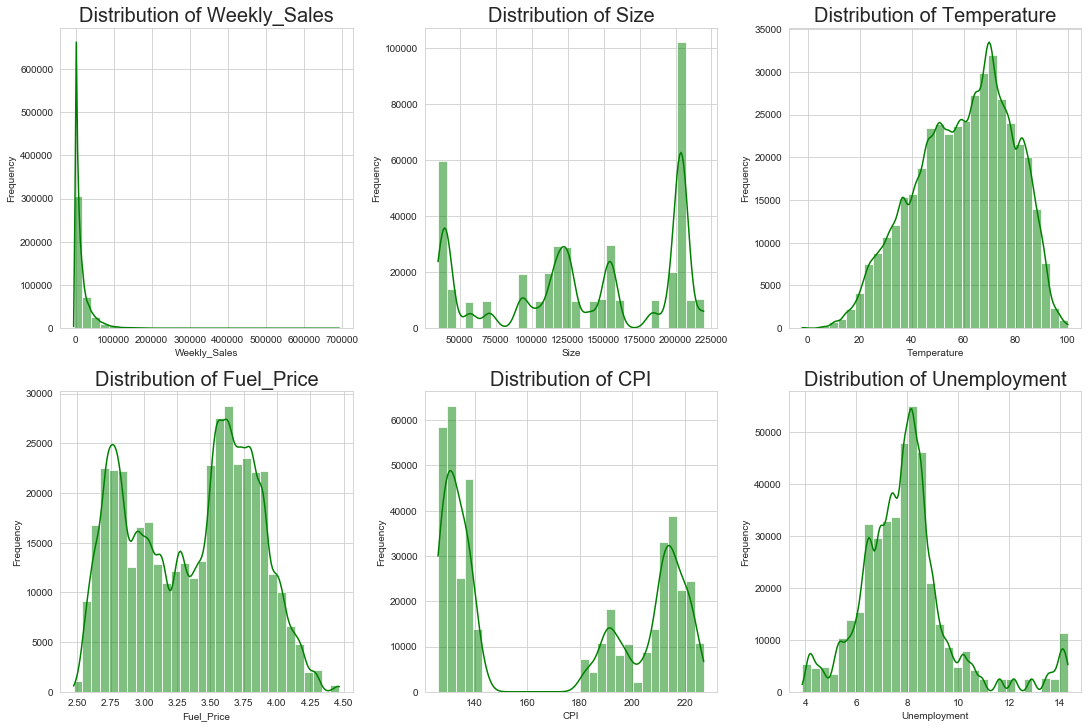

In [35]:
num_cols = 3
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), constrained_layout=True)

axes = axes.flatten()



# Draw Histogram for each attribute
for idx, col in enumerate(numerical_cols):
   
    
    
    sns.histplot(df[col], bins=30, kde=True, color='g', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.show()

In [36]:
numerical_cols2 = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

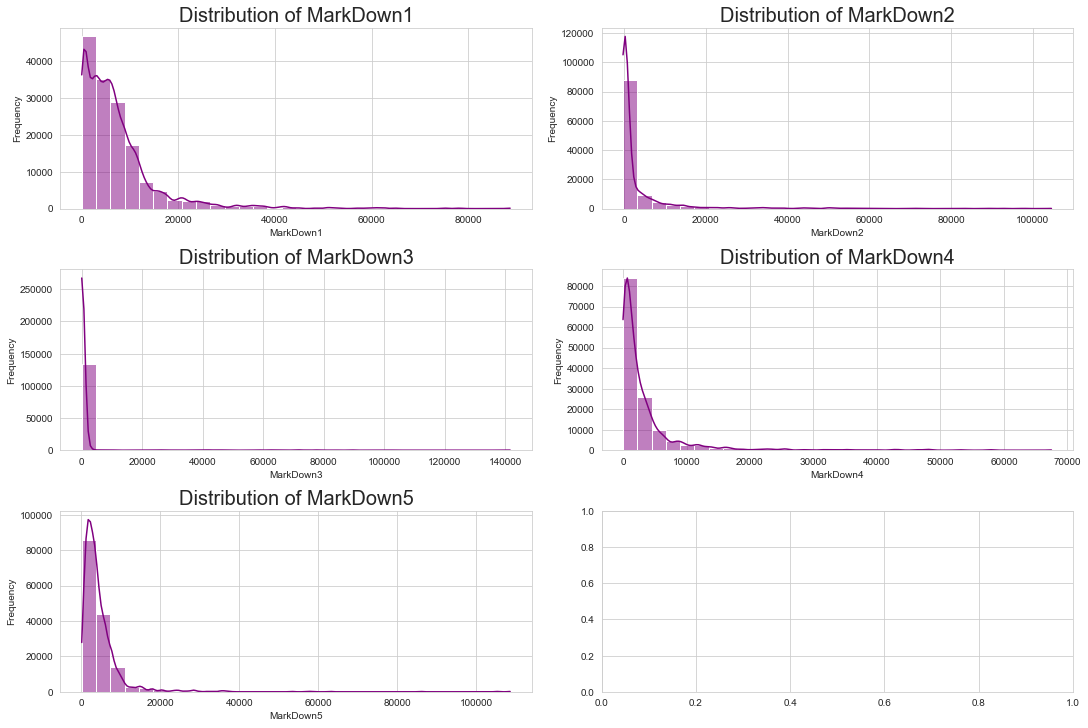

In [37]:
num_cols = 2
num_rows = (len(numerical_cols2) + num_cols - 1) // num_cols

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), constrained_layout=True)

axes = axes.flatten()



# Draw Histogram for each attribute
for idx, col in enumerate(numerical_cols2):
   
    
    
    sns.histplot(df[col], bins=30, kde=True, color='purple', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')


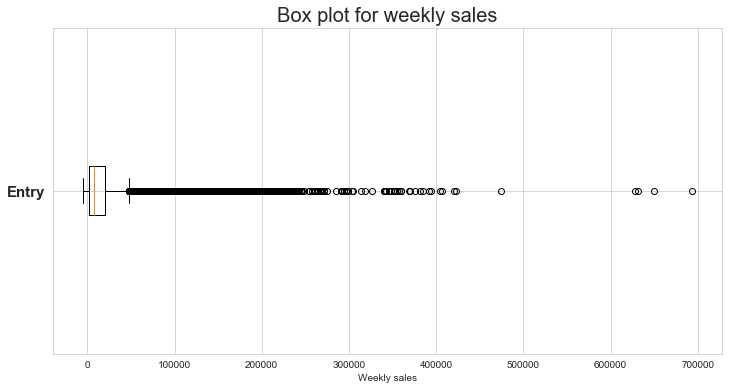

In [38]:
plt.figure(figsize=(12,6))
plt.boxplot(df['Weekly_Sales'], vert=False)
plt.title('Box plot for weekly sales')
plt.xlabel('Weekly sales')
plt.yticks(ticks=[1], labels=['Entry'], fontsize=15, fontweight='bold')
plt.show()

In [39]:
# Add a constant to shift the values as data contain negative and 0 values
shift_constant = abs(df['Weekly_Sales'].min()) + 1
df['Log_Weekly_Sales'] = np.log(df['Weekly_Sales'] + shift_constant)

# Apply log transformation to weekly sales as it skewed and has outliers

df['Log_Weekly_Sales'] = np.log(df['Weekly_Sales'])

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hp\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


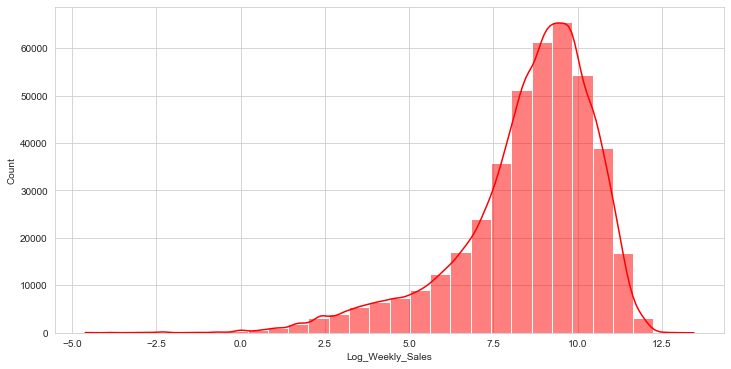

In [40]:
plt.figure(figsize=(12,6))
sns.histplot(df['Log_Weekly_Sales'], bins=30, kde=True, color='r')
plt.show()

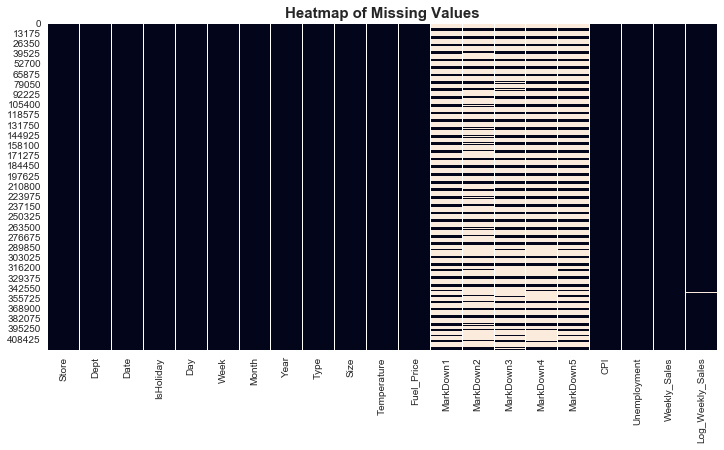

In [41]:
# Heatmap of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='rocket')
plt.title('Heatmap of Missing Values', fontsize=15, fontweight='bold')
plt.show()

In [42]:
df

,Store,Dept,Date,IsHoliday,Day,Week,Month,Year,Type,Size,...,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales,Log_Weekly_Sales
0,1,1,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,24924.50,10.123607
1,1,2,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,50605.27,10.831811
2,1,3,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,13740.12,9.528075
3,1,4,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,39954.04,10.595485
4,1,5,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,32229.38,10.380634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,False,26,43,10,2012,B,118221,...,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2487.80,7.819154
421566,45,94,2012-10-26,False,26,43,10,2012,B,118221,...,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,5203.31,8.557050
421567,45,95,2012-10-26,False,26,43,10,2012,B,118221,...,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,56017.47,10.933419
421568,45,97,2012-10-26,False,26,43,10,2012,B,118221,...,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,6817.48,8.827245


In [43]:
store_counts = df['Store'].value_counts().reset_index()
store_counts.columns = ['Store', 'Count']


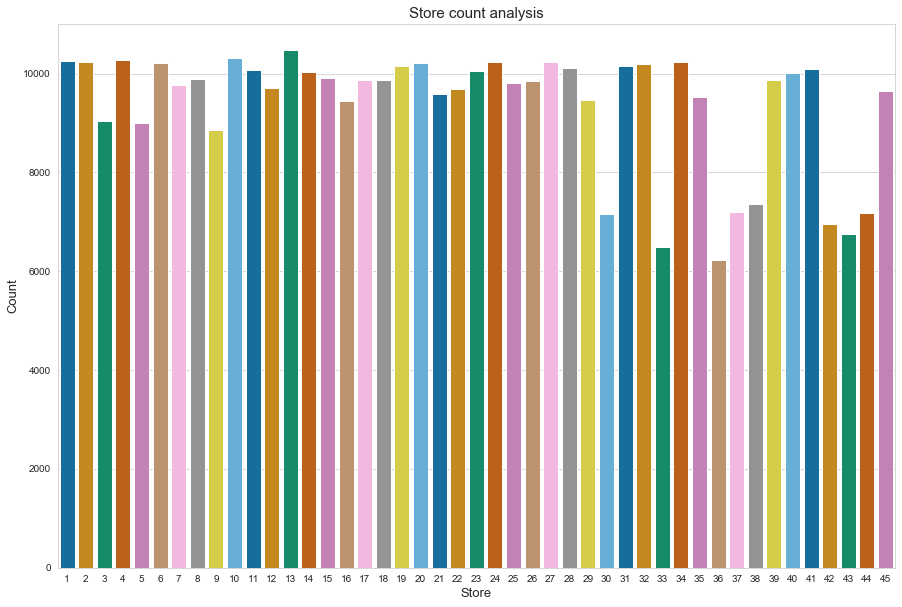

In [44]:
# Plotting the count of each store in our data

plt.figure(figsize=(15,10))
sns.barplot(x=store_counts['Store'], y=store_counts['Count'], palette='colorblind')
plt.title('Store count analysis', fontsize=15)
plt.xlabel('Store', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

In [45]:
dept_c = df['Dept'].value_counts().reset_index()
dept_c.columns = ['Dept', 'Count']

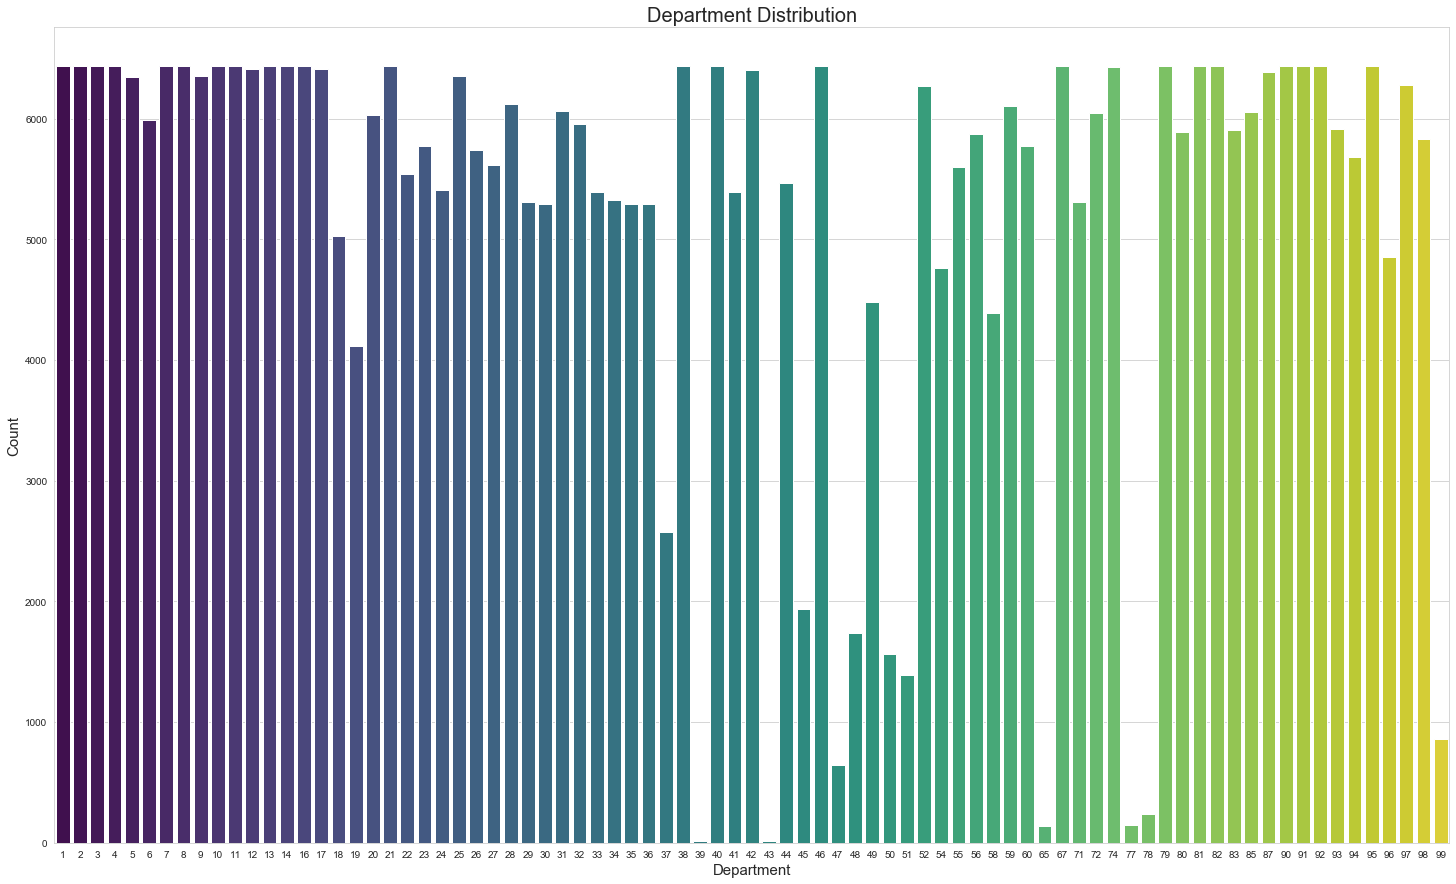

In [46]:
#  Plotting the count of each department in our data

plt.figure(figsize=(25, 15))
sns.barplot(x='Dept', y='Count', data=dept_c, palette='viridis')
plt.xlabel('Department', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Department Distribution', fontsize=20)
plt.show()

In [47]:
cIsholiday = df['IsHoliday'].value_counts().reset_index()
cIsholiday.columns = ['IsHoliday', 'Count']

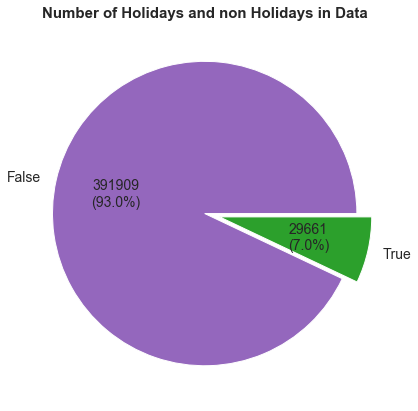

In [48]:
explode = (0, 0.1) # only explode the 2nd slice
colors = [ '#9467bd', '#2ca02c'] 

plt.figure(figsize=(10,7))
plt.pie(cIsholiday['Count'], labels=cIsholiday['IsHoliday'], explode=explode, 
        autopct=lambda p: f'{int(p * sum(cIsholiday["Count"]) / 100.0)}\n({p:.1f}%)', 
        textprops={'fontsize': 14, 'fontweight':20}, colors=colors)

plt.title('Number of Holidays and non Holidays in Data', fontsize=15, fontweight='bold')
plt.show()

In [49]:
storeType = df['Type'].value_counts().reset_index()
storeType.columns = ['Type', 'Count']

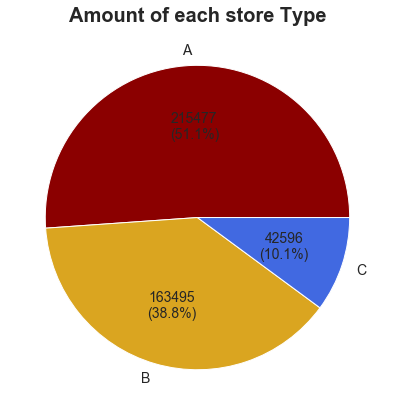

In [50]:
colors = ['#8b0000', '#daa520', '#4169e1']

plt.figure(figsize=(10,7
                   ))
plt.pie(storeType['Count'], labels=storeType['Type'], 
        autopct=lambda p: f'{int(p * sum(cIsholiday["Count"]) / 100.0)}\n({p:.1f}%)', 
        textprops={'fontsize': 14}, colors=colors)
plt.title('Amount of each store Type', fontsize=20, fontweight='bold')
plt.show()

In [51]:
# Extract the holidays in the dataset

Holidays = df[df['IsHoliday'] == True]
Holidays.drop_duplicates(subset='Date', inplace=True)
Holidays = Holidays['Date'].tolist()
print(Holidays)

[Timestamp('2010-02-12 00:00:00'), Timestamp('2010-09-10 00:00:00'), Timestamp('2010-11-26 00:00:00'), Timestamp('2010-12-31 00:00:00'), Timestamp('2011-02-11 00:00:00'), Timestamp('2011-09-09 00:00:00'), Timestamp('2011-11-25 00:00:00'), Timestamp('2011-12-30 00:00:00'), Timestamp('2012-02-10 00:00:00'), Timestamp('2012-09-07 00:00:00')]


C:\Users\hp\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Bivariate analysis

In [52]:
df.corr()

,Store,Dept,IsHoliday,Day,Week,Month,Year,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales,Log_Weekly_Sales
Store,1.000000,0.024004,-0.000548,-0.000015,0.001031,0.001011,0.002997,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552,-0.085195,-0.134671
Dept,0.024004,1.000000,0.000916,-0.000678,0.000882,0.000904,0.003738,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837,0.148032,0.021397
IsHoliday,-0.000548,0.000916,1.000000,0.045465,0.128184,0.123376,-0.056746,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460,0.012774,0.005689
Day,-0.000015,-0.000678,0.045465,1.000000,0.104719,0.016363,0.005835,-0.000386,0.026832,0.028058,-0.292096,0.064475,0.137674,-0.312683,-0.139004,0.002744,-0.003793,-0.006187,-0.003532
Week,0.001031,0.000882,0.128184,0.104719,1.000000,0.995999,-0.181797,-0.001292,0.236276,-0.031140,-0.198076,-0.000995,0.196307,-0.218477,0.084874,0.006342,-0.015490,0.027673,0.020857
Month,0.001011,0.000904,0.123376,0.016363,0.995999,1.000000,-0.194288,-0.001210,0.235983,-0.040876,-0.176188,-0.005310,0.187871,-0.194865,0.097347,0.005282,-0.012444,0.028409,0.021424
Year,0.002997,0.003738,-0.056746,0.005835,-0.181797,-0.194288,1.000000,-0.004975,0.065814,0.779633,0.141332,-0.222109,-0.319162,0.126469,-0.128387,0.074544,-0.237161,-0.010111,-0.017460
Size,-0.182881,-0.002966,0.000593,-0.000386,-0.001292,-0.001210,-0.004975,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238,0.243828,0.315610
Temperature,-0.050097,0.004437,-0.155949,0.026832,0.236276,0.235983,0.065814,-0.058313,1.000000,0.143859,-0.040594,-0.323927,-0.096880,-0.063947,-0.017544,0.182112,0.096730,-0.002312,-0.041517
Fuel_Price,0.065290,0.003572,-0.078281,0.028058,-0.031140,-0.040876,0.779633,0.003361,0.143859,1.000000,0.061371,-0.220895,-0.102092,-0.044986,-0.128065,-0.164210,-0.033853,-0.000120,-0.006030


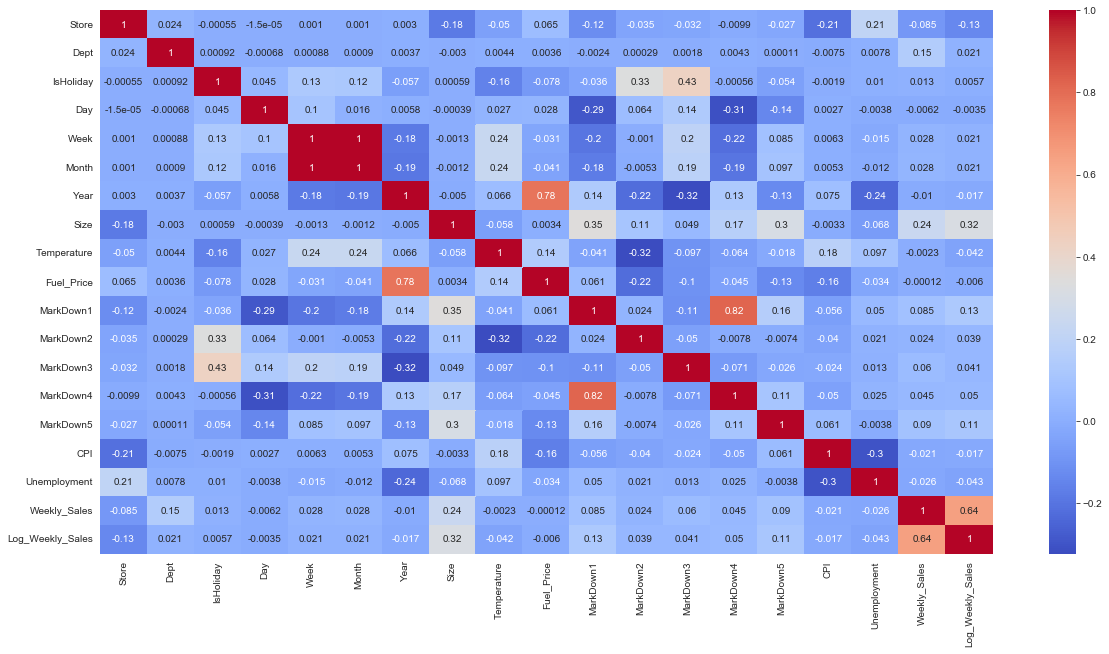

In [53]:
# Heat Map to preview correlation between attributes

plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [54]:
weekly_sales_corr = df.corr().iloc[17,:]
corr_df = pd.DataFrame(data = weekly_sales_corr, 
                       index = weekly_sales_corr.index ).sort_values(by='Weekly_Sales', ascending=False)
corr_df = corr_df.iloc[2:]

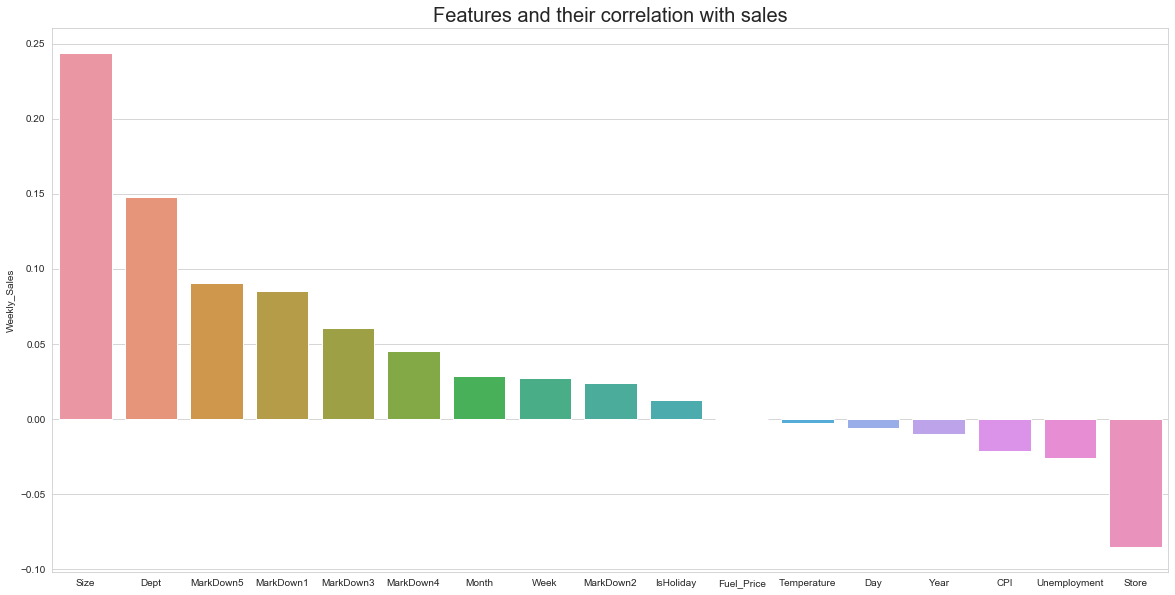

In [55]:
plt.figure(figsize=(20,10))
sns.barplot(corr_df, x=corr_df.index, y='Weekly_Sales')
plt.title('Features and their correlation with sales', fontsize=20)
plt.show()

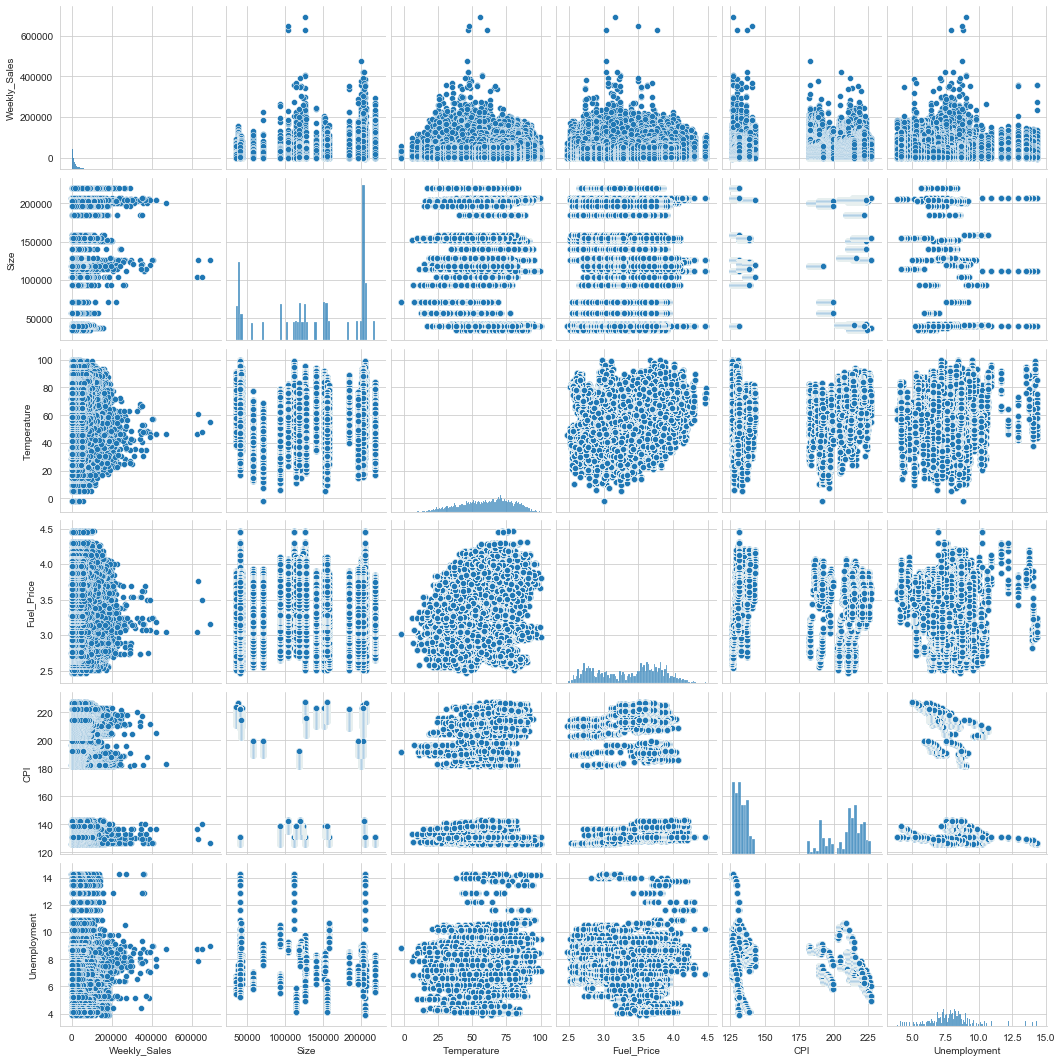

In [56]:
sns.pairplot(df[numerical_cols])
plt.show()

In [57]:
# Create a df that has every dept and the average of weekly sales

avg_dept_sales = df.groupby('Dept')['Weekly_Sales'].mean().reset_index()

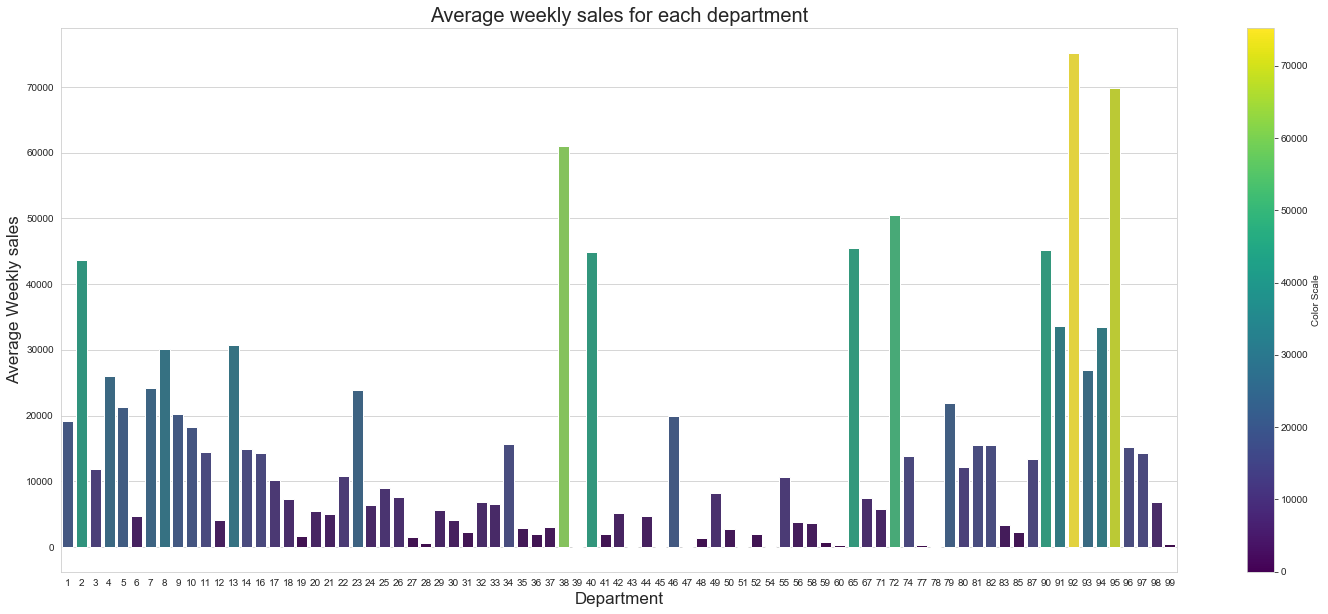

In [58]:
# Create a custom colormap based on the 'viridis' colormap
cmap = plt.cm.get_cmap('viridis')

# Normalize 'Value' to range [0, 1] for colormap
norm = mcolors.Normalize(vmin=avg_dept_sales['Weekly_Sales'].min(), vmax=avg_dept_sales['Weekly_Sales'].max())

# Convert weekly_sales to colormap colors
colors = [cmap(norm(value)) for value in avg_dept_sales['Weekly_Sales']]

# Bar plot to visualize the average weekly sales of each department

plt.figure(figsize=(25,10))
sns.barplot(x=avg_dept_sales['Dept'], y=avg_dept_sales['Weekly_Sales'], palette=colors)
plt.title('Average weekly sales for each department', fontsize=20)
plt.xlabel('Department', fontsize=17)
plt.ylabel('Average Weekly sales', fontsize=17)


# Adding color bar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Color Scale')

plt.show()

In [59]:
# Filter DataFrame for holiday sales
holiday_sales = df[df['IsHoliday'] == True]

# Aggregate sales by department and sort to get top 20
top_departments = holiday_sales.groupby('Dept')['Weekly_Sales'].sum().nlargest(30).index

# Filter DataFrame for top 20 departments
top_dept_sales = df[df['Dept'].isin(top_departments)]

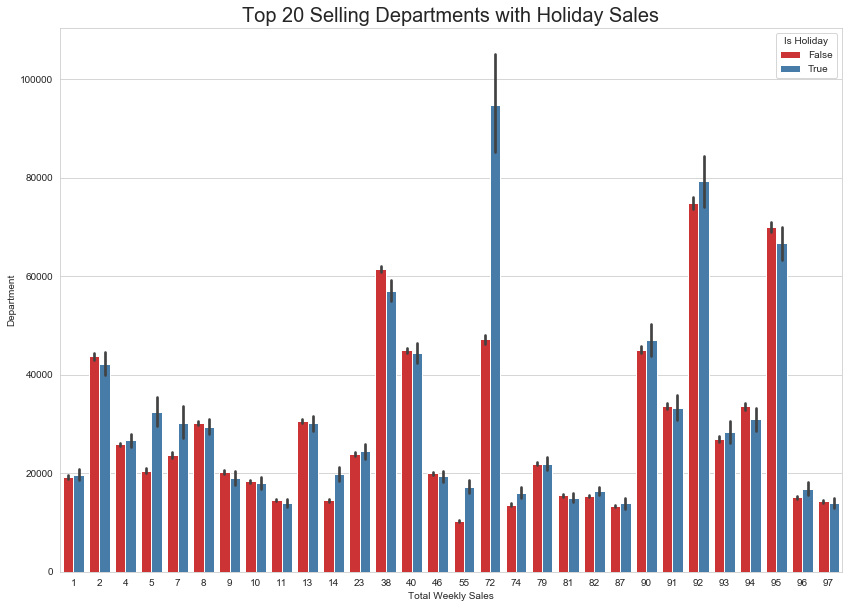

In [60]:
# Bar plot for top 20 selling Departments and their sales on normal and holidays

plt.figure(figsize=(14, 10))
sns.barplot(data=top_dept_sales, y='Weekly_Sales', x='Dept', hue='IsHoliday', palette='Set1')
plt.title('Top 20 Selling Departments with Holiday Sales')
plt.xlabel('Total Weekly Sales')
plt.ylabel('Department')
plt.legend(title='Is Holiday')
plt.show()

<Figure size 2880x1440 with 0 Axes>

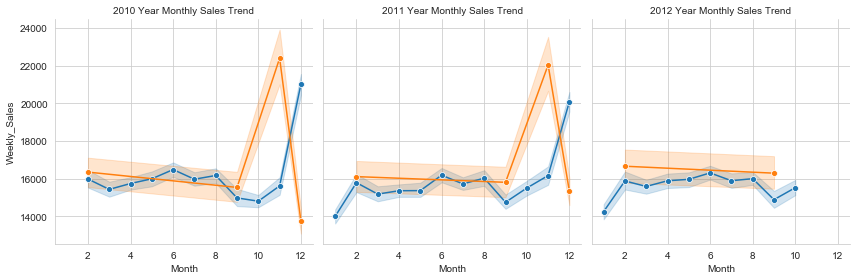

In [61]:
# Line chart between Weekly Sales and Monthly Sales

plt.figure(figsize=(40,20))
g = sns.FacetGrid(df, col="Year", col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, 'Month', 'Weekly_Sales', 'IsHoliday', marker='o')
g.set_titles("{col_name} Year Monthly Sales Trend", fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)

plt.show()

In [62]:
print(df['Week'].min(), df['Week'].max())

1 52


In [63]:
df_2010 = df[df['Year'] == 2011]

In [64]:
ticks = [i for i in range(1, df['Week'].nunique())]

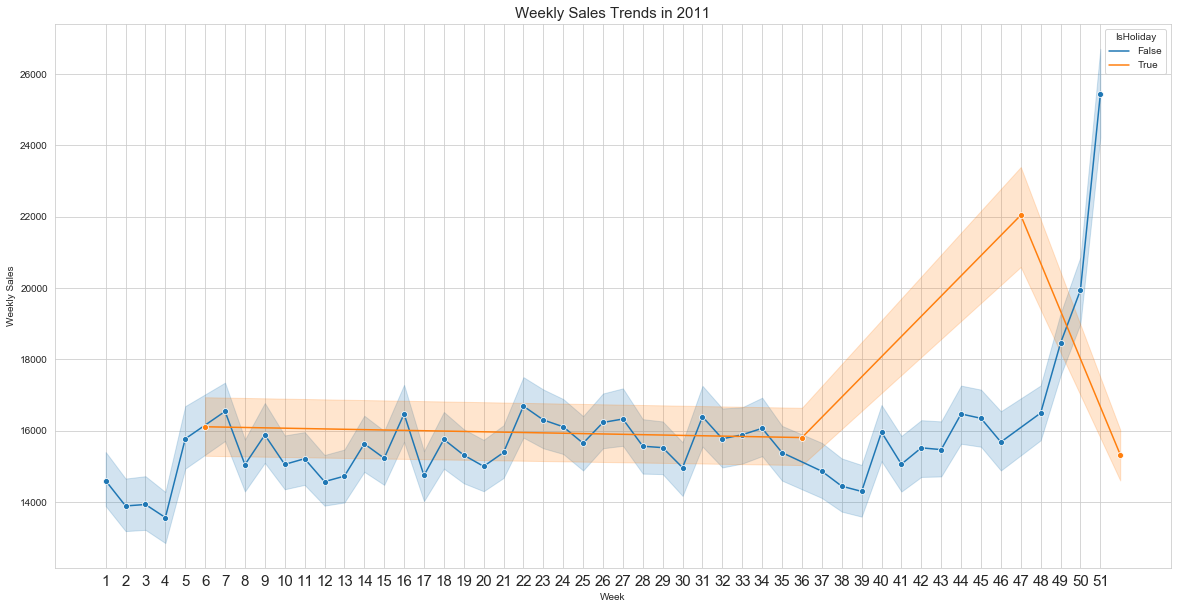

In [65]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df_2010['Week'], y=df_2010['Weekly_Sales'], marker='o', hue=df_2010['IsHoliday'])
plt.title('Weekly Sales Trends in 2011', fontsize=15)
plt.xticks(ticks, fontsize=15)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Weekly Sales', fontsize=10)

plt.show()

In [66]:
Holidays

[Timestamp('2010-02-12 00:00:00'),
 Timestamp('2010-09-10 00:00:00'),
 Timestamp('2010-11-26 00:00:00'),
 Timestamp('2010-12-31 00:00:00'),
 Timestamp('2011-02-11 00:00:00'),
 Timestamp('2011-09-09 00:00:00'),
 Timestamp('2011-11-25 00:00:00'),
 Timestamp('2011-12-30 00:00:00'),
 Timestamp('2012-02-10 00:00:00'),
 Timestamp('2012-09-07 00:00:00')]

We can deduce that sales by the end of the year increases but sales drop a lot in first month of every year

In [67]:
store_sales = df.groupby(['Store', 'Type'])['Weekly_Sales'].mean().sort_values(ascending=False).reset_index()
store_sales['Store'] = store_sales['Store'].astype(str)

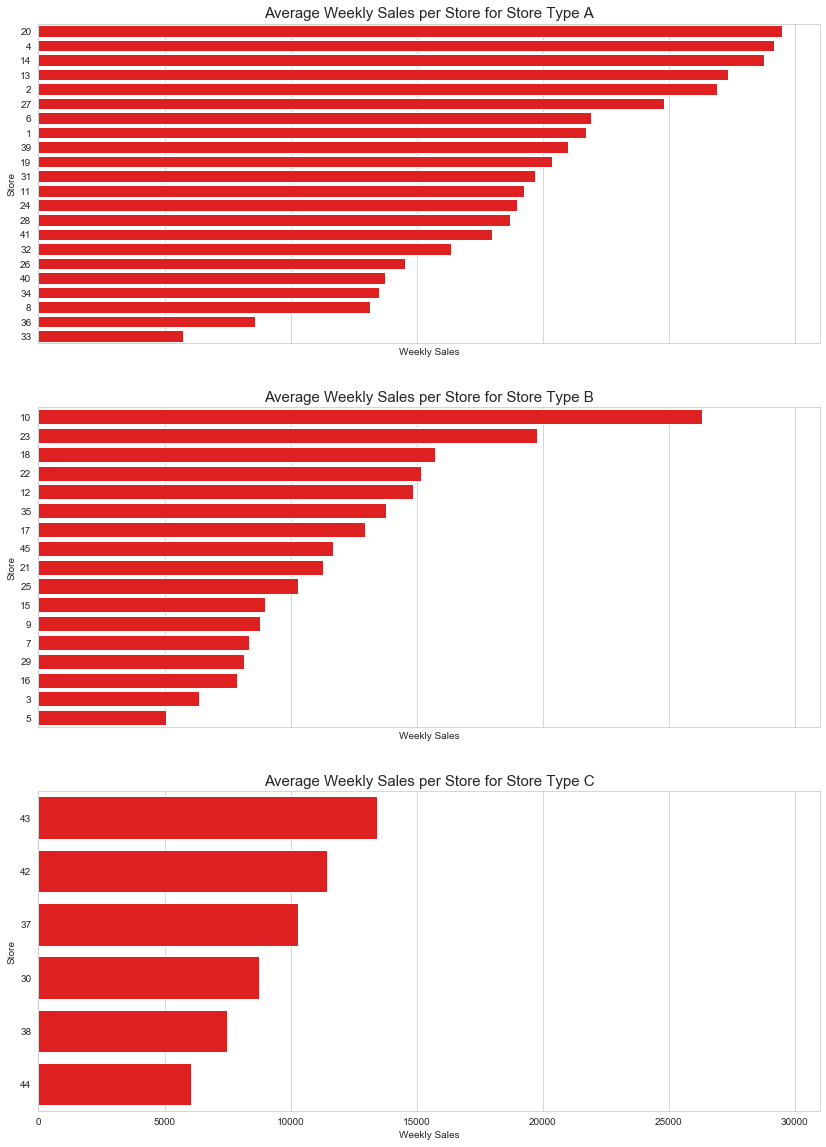

In [68]:
# Get unique store types
store_types = df['Type'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(store_types), ncols=1, figsize=(14, 20), sharex=True)

# Plot each type in a separate subplot
for i, store_type in enumerate(store_types):
    ax = axes[i]
    subset = store_sales[store_sales['Type'] == store_type]
    sns.barplot(data=subset, x='Weekly_Sales', y='Store', ax=ax, orient='h', color='r')
    ax.set_title(f'Average Weekly Sales per Store for Store Type {store_type}', fontsize=15)
    ax.set_xlabel('Weekly Sales')
    ax.set_ylabel('Store')

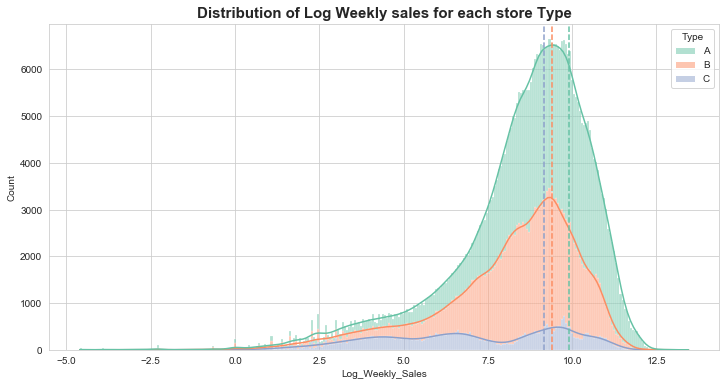

In [69]:
plt.figure(figsize=(12,6))
sns.histplot(df, x='Log_Weekly_Sales', hue='Type', kde=True, multiple='stack', palette='Set2')

# Calculate and add mean lines for each store type
store_types = df['Type'].unique()
colors = sns.color_palette('Set2', len(store_types))

for store_type, color in zip(store_types, colors):
    mean_value = df[df['Type'] == store_type]['Weekly_Sales'].mean()
    mean_value = np.log(mean_value)
    plt.axvline(mean_value, color=color, linestyle='--', label=f'Mean (Store {store_type})')
    
    
plt.title('Distribution of Log Weekly sales for each store Type', fontsize=15, fontweight='bold')    
plt.show()

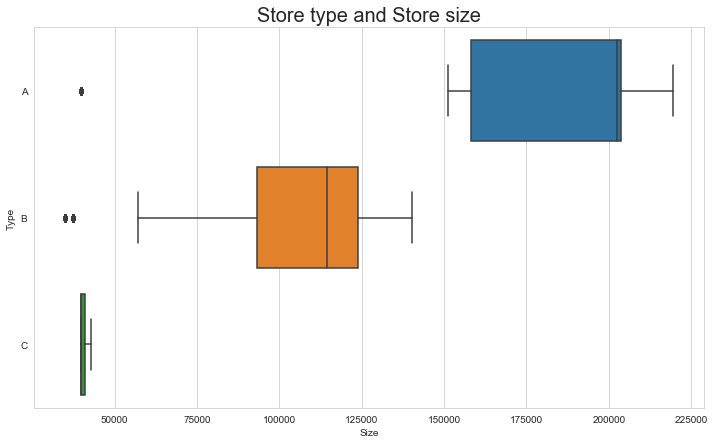

In [70]:
# Boxplot between Store Type and Size

plt.figure(figsize=(12,7))
sns.boxplot(df, y='Type', x='Size')
plt.title('Store type and Store size')
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: n
  


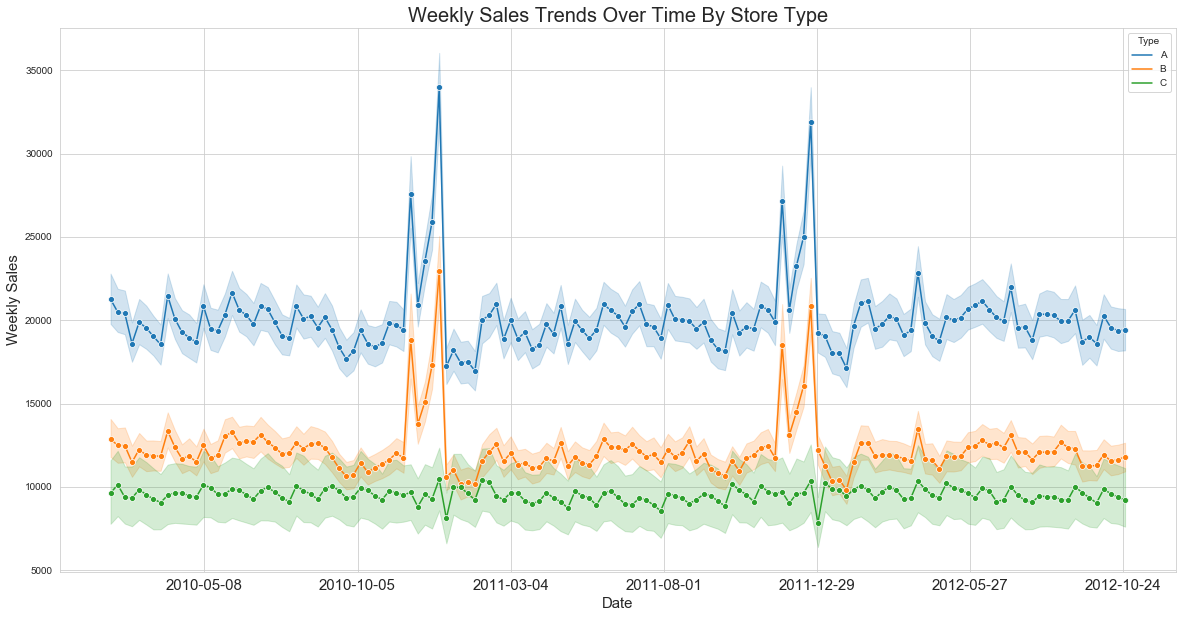

In [71]:
# Line chart between Weekly Sales and Date

plt.figure(figsize=(20,10))
sns.lineplot(x=df['Date'], y=df['Weekly_Sales'], hue=df['Type'], marker='o')
plt.xticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(n=1))
plt.title('Weekly Sales Trends Over Time By Store Type', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)

plt.show()

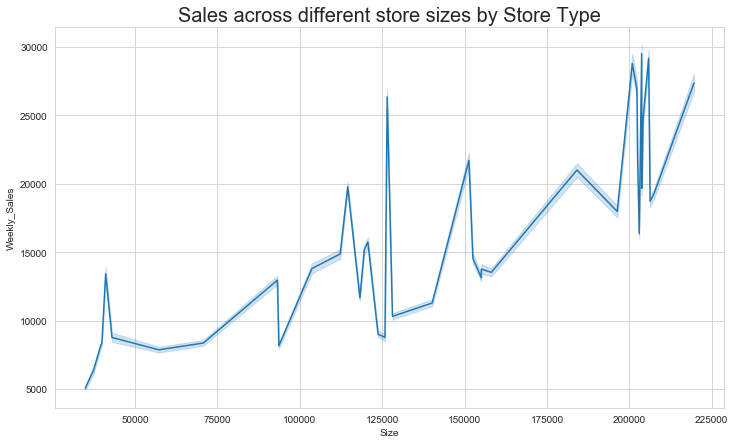

In [72]:
# Line plot to show the relation between sales and store size

plt.figure(figsize=(12,7))
sns.lineplot(df, x='Size', y='Weekly_Sales')
plt.title('Sales across different store sizes by Store Type')
plt.show()

In [73]:
df.head()

,Store,Dept,Date,IsHoliday,Day,Week,Month,Year,Type,Size,...,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales,Log_Weekly_Sales
0,1,1,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,24924.50,10.123607
1,1,2,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,50605.27,10.831811
2,1,3,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,13740.12,9.528075
3,1,4,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,39954.04,10.595485
4,1,5,2010-02-05,False,5,5,2,2010,A,151315,...,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,32229.38,10.380634


# Data Cleaning: Part 2

- Filled all Null values with 0
- Store Types reclassified to fit their category based on their size ( A & B type stores had small sizes that fit into category C )

In [74]:
df.fillna(0, inplace=True) # Fill all NaN with 0

In [75]:
test.fillna(0, inplace=True) # Fill all NaN with 0

In [76]:
df.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Day                 0
Week                0
Month               0
Year                0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1           0
MarkDown2           0
MarkDown3           0
MarkDown4           0
MarkDown5           0
CPI                 0
Unemployment        0
Weekly_Sales        0
Log_Weekly_Sales    0
dtype: int64

In [77]:
df.groupby('Type')['Size'].mean()

Type
A    182231.285486
B    101818.735827
C     40535.725286
Name: Size, dtype: float64

In [78]:
# Getting median, Q3, Q1, IQR and Lower Limit for each store type

type_stat = df.groupby('Type')['Size'].agg(
    Median='median',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75),
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
).reset_index()

type_stat['Lower_Limit'] = type_stat['Q1'] - 1.5*type_stat['IQR']
print(type_stat)

  Type    Median        Q1        Q3      IQR  Lower_Limit
0    A  202505.0  158114.0  203819.0  45705.0      89556.5
1    B  114533.0   93188.0  123737.0  30549.0      47364.5
2    C   39910.0   39690.0   41062.0   1372.0      37632.0


In [79]:
# Create a dictionary for quick lookup
type_limits = type_stat.set_index('Type')['Lower_Limit'].to_dict()
type_limits

{'A': 89556.5, 'B': 47364.5, 'C': 37632.0}

In [80]:
# Function to classify stores
def reclassify_store(row, limits):
    current_type = row['Type']
    current_size = row['Size']
    
    # Check if current size is less than the lower limit of the current type
    if current_size < limits[current_type]:
        
        for store_type, bounds in limits.items():
            if limits['B'] < current_size < limits['A']: # If size is between lower limit A and limit B return store_type B
                return 'B'
            elif current_size < limits['B']: # If size is less than Lower limit for B return store_type C
                return 'C'
    return current_type # Return current if no classification needed



In [81]:
store['New_Type'] = store.apply(reclassify_store, axis=1, limits=type_limits)
store[store['Type'] != store['New_Type']]

,Store,Type,Size,New_Type
2,3,B,37392,C
4,5,B,34875,C
32,33,A,39690,C
35,36,A,39910,C


In [82]:
# Applying classification function to original DF
df['New_Type'] = df.apply(reclassify_store, axis=1, limits=type_limits) 
test['New_Type'] = test.apply(reclassify_store, axis=1, limits=type_limits)

# Feature Engineering

### Feature Generation

In [83]:
df.head()

,Store,Dept,Date,IsHoliday,Day,Week,Month,Year,Type,Size,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales,Log_Weekly_Sales,New_Type
0,1,1,2010-02-05,False,5,5,2,2010,A,151315,...,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,24924.50,10.123607,A
1,1,2,2010-02-05,False,5,5,2,2010,A,151315,...,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,50605.27,10.831811,A
2,1,3,2010-02-05,False,5,5,2,2010,A,151315,...,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,13740.12,9.528075,A
3,1,4,2010-02-05,False,5,5,2,2010,A,151315,...,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,39954.04,10.595485,A
4,1,5,2010-02-05,False,5,5,2,2010,A,151315,...,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,32229.38,10.380634,A


In [84]:
data_train = df.copy() 
data_test = test.copy()

We have 4 holiday weeks in a calender year, Superbowl, Labor Day, Thanksgiving & Christmas

We can go ahead and specify the holiday for every holiday week instead of having it as True & False 

In [85]:
data_train['SuperBowlWeek'] = df['Week'].apply(lambda x: 1 if x == 6 else 0)
data_train['LaborWeek'] = df['Week'].apply(lambda x: 1 if x == 36 else 0)
data_train['ThanksgivingWeek'] = df['Week'].apply(lambda x: 1 if x == 47 else 0)
data_train['ChristmasWeek'] = df['Week'].apply(lambda x: 1 if x == 52 else 0)

In [86]:
data_test['SuperBowlWeek'] = test['Week'].apply(lambda x: 1 if x == 6 else 0)
data_test['LaborWeek'] = test['Week'].apply(lambda x: 1 if x == 36 else 0)
data_test['ThanksgivingWeek'] = test['Week'].apply(lambda x: 1 if x == 47 else 0)
data_test['ChristmasWeek'] = test['Week'].apply(lambda x: 1 if x == 52 else 0)

Most important holidays are Christmas and Thanksgiving when it comes to shopping

In [87]:
data_train['Days_2_Thansksgiving'] = (pd.to_datetime(df["Year"].astype(str)+"-11-24", format="%Y-%m-%d") 
                                       - df["Date"]).dt.days.astype(int)
data_train['Days_2_Christmas'] = (pd.to_datetime(df['Year'].astype(str)+"-12-24", format='%Y-%m-%d') 
                                  - df['Date']).dt.days.astype(int)

In [88]:
data_test['Days_2_Thansksgiving'] = (pd.to_datetime(test["Year"].astype(str)+"-11-24", format="%Y-%m-%d") 
                                       - test["Date"]).dt.days.astype(int)
data_test['Days_2_Christmas'] = (pd.to_datetime(test['Year'].astype(str)+"-12-24", format='%Y-%m-%d') 
                                  - test['Date']).dt.days.astype(int)

In [89]:
data_train['Total_MarkDown'] = df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5']

In [90]:
data_test['Total_MarkDown'] = test['MarkDown1'] + test['MarkDown2'] + test['MarkDown3'] + test['MarkDown4'] + test['MarkDown5']

In [91]:
print(data_test.shape, data_train.shape)

(115064, 28) (421570, 29)


### Feature Preprocessing

Encoding features

In [92]:
# Encoding store Type

data_train['Type_Encoded'] = data_train['New_Type'].map({'A': 3, 'B': 2, 'C': 1})
data_test['Type_Encoded'] = data_test['New_Type'].map({'A': 3, 'B': 2, 'C': 1})

In [93]:
# Target encoding Department column
data_train = pd.merge(data_train, avg_dept_sales, on=['Dept'])

In [94]:
data_train.rename(columns={'Weekly_Sales_x': 'Weekly_Sales', 'Weekly_Sales_y': 'Avg_Dept_Sales'}, inplace=True)

In [95]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 115064 non-null  int64         
 1   Dept                  115064 non-null  int64         
 2   Date                  115064 non-null  datetime64[ns]
 3   IsHoliday_x           115064 non-null  bool          
 4   Day                   115064 non-null  int64         
 5   Week                  115064 non-null  int64         
 6   Month                 115064 non-null  int64         
 7   Year                  115064 non-null  int64         
 8   Type                  115064 non-null  object        
 9   Size                  115064 non-null  int64         
 10  Temperature           115064 non-null  float64       
 11  Fuel_Price            115064 non-null  float64       
 12  MarkDown1             115064 non-null  float64       
 13 

In [96]:
# Target encoding store column
store_sales = store_sales.drop(columns=['Type'])
store_sales['Store'] = pd.to_numeric(store_sales['Store'])
data_train = pd.merge(data_train, store_sales, on=['Store'])


In [97]:
data_train.rename(columns={'Weekly_Sales_y': 'Avg_Store_Sales'}, inplace=True)

In [98]:
data_test = pd.merge(data_test, avg_dept_sales, on=['Dept'])
data_test = pd.merge(data_test, store_sales, on=['Store'])

In [99]:
data_test.rename(columns={'Weekly_Sales_x': 'Avg_Dept_Sales', 'Weekly_Sales_y': 'Avg_Store_Sales'}, inplace=True)

In [100]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 421570 non-null  int64         
 1   Dept                  421570 non-null  int64         
 2   Date                  421570 non-null  datetime64[ns]
 3   IsHoliday             421570 non-null  bool          
 4   Day                   421570 non-null  int64         
 5   Week                  421570 non-null  int64         
 6   Month                 421570 non-null  int64         
 7   Year                  421570 non-null  int64         
 8   Type                  421570 non-null  object        
 9   Size                  421570 non-null  int64         
 10  Temperature           421570 non-null  float64       
 11  Fuel_Price            421570 non-null  float64       
 12  MarkDown1             421570 non-null  float64       
 13 

In [101]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 115064 non-null  int64         
 1   Dept                  115064 non-null  int64         
 2   Date                  115064 non-null  datetime64[ns]
 3   IsHoliday_x           115064 non-null  bool          
 4   Day                   115064 non-null  int64         
 5   Week                  115064 non-null  int64         
 6   Month                 115064 non-null  int64         
 7   Year                  115064 non-null  int64         
 8   Type                  115064 non-null  object        
 9   Size                  115064 non-null  int64         
 10  Temperature           115064 non-null  float64       
 11  Fuel_Price            115064 non-null  float64       
 12  MarkDown1             115064 non-null  float64       
 13 

# Feature Selection

First let's check out if we have any kind of multicollinearity

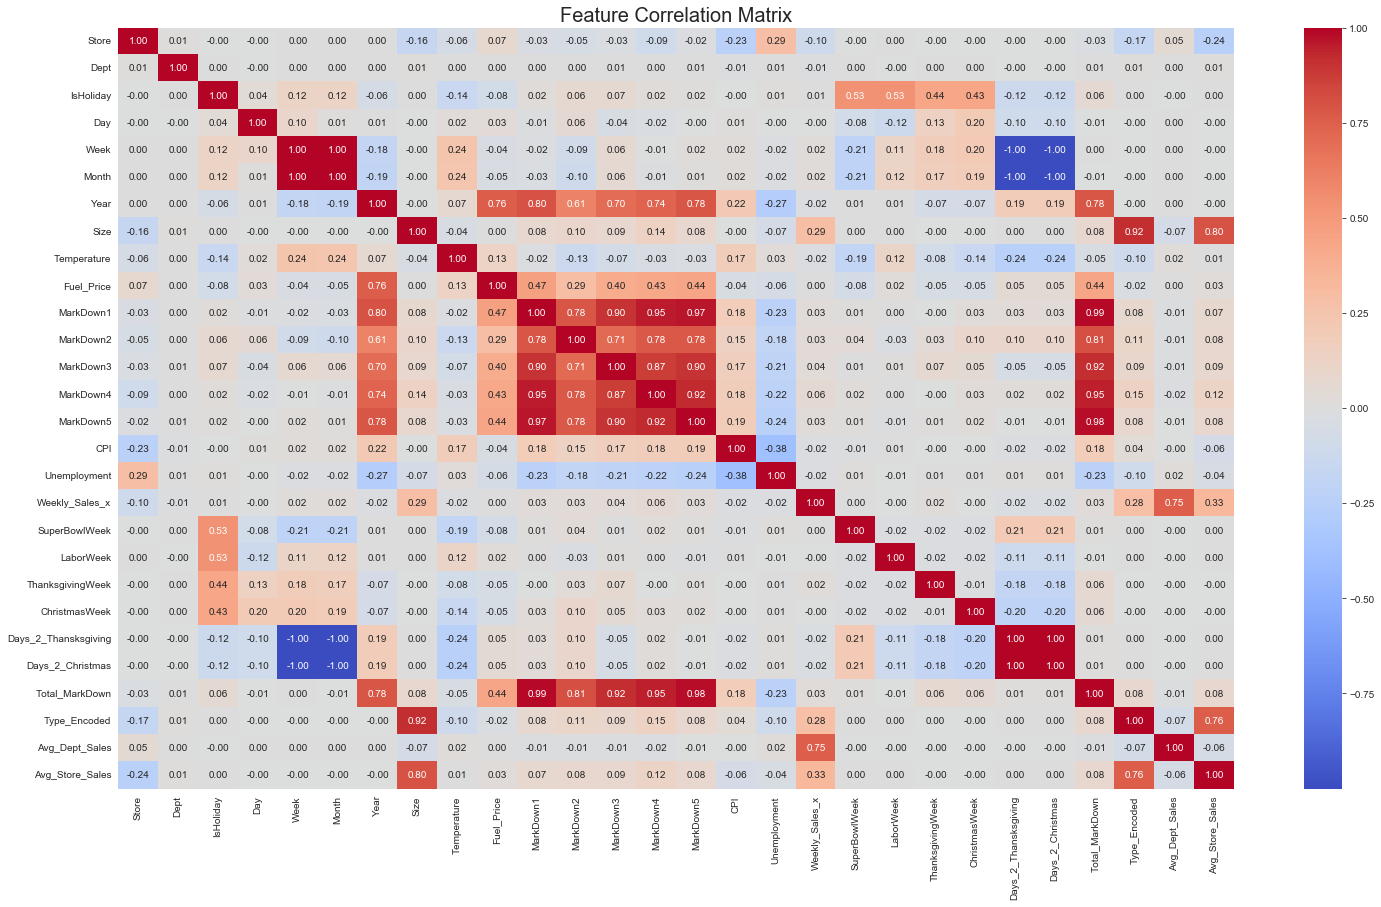

In [102]:
# Compute the correlation matrix
corr_matrix = data_train.drop(columns=['Log_Weekly_Sales']).corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(25, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [103]:
num_cols = data_train.select_dtypes(include=['number']).columns.tolist()

In [104]:
# Conducting correlation analysis using spearman's

results = []
alpha = 0.05 # Significance level

for col in num_cols:
    rho, pval = stats.spearmanr(data_train['Weekly_Sales_x'], data_train[col])
    if pval < alpha:
        hyp = 'Reject'
    else:
        hyp = 'Fail to Reject'
    results.append([col, rho, pval, hyp])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Feature', 'SpearmanRho', 'PValue', 'Hypothesis_result'])


results_df

,Feature,SpearmanRho,PValue,Hypothesis_result
0,Store,-0.102241,0.000000e+00,Reject
1,Dept,-0.013764,3.988935e-19,Reject
2,Day,-0.004438,3.958684e-03,Reject
3,Week,0.023328,7.769238e-52,Reject
4,Month,0.023872,3.363930e-54,Reject
5,Year,-0.016781,1.197745e-27,Reject
6,Size,0.289973,0.000000e+00,Reject
7,Temperature,-0.019752,1.178322e-37,Reject
8,Fuel_Price,0.001993,1.956404e-01,Fail to Reject
9,MarkDown1,0.028768,6.868661e-78,Reject


We'll remove columns with high corr to each other to eliminate multicollinearity 

- MarkDowns with Total Markdown
- Type_Encoded with Size has a correlation of 0.92 (We'll remove Type&Type_Encoded as they have less correlation with Weekly Sales than Size)

We'll also remove Fuel_Price as it has very low P-Value and Spearman rho almost 0

In [105]:
remove = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type_Encoded', 'Fuel_Price', 'Type', 'New_Type'
          ,'Date']
data_train.drop(labels=remove, axis=1, inplace=True)

In [106]:
temp = data_train.pop('Weekly_Sales_x')
data_train['Weekly_Sales'] = temp

In [107]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Store                 421570 non-null  int64  
 1   Dept                  421570 non-null  int64  
 2   IsHoliday             421570 non-null  bool   
 3   Day                   421570 non-null  int64  
 4   Week                  421570 non-null  int64  
 5   Month                 421570 non-null  int64  
 6   Year                  421570 non-null  int64  
 7   Size                  421570 non-null  int64  
 8   Temperature           421570 non-null  float64
 9   CPI                   421570 non-null  float64
 10  Unemployment          421570 non-null  float64
 11  Log_Weekly_Sales      421570 non-null  float64
 12  SuperBowlWeek         421570 non-null  int64  
 13  LaborWeek             421570 non-null  int64  
 14  ThanksgivingWeek      421570 non-null  int64  
 15  

Data split into train and test data

In [108]:
# Separate the data into two groups based on IsHoliday

holiday_data = data_train[data_train['IsHoliday'] == True]
non_holiday_data = data_train[data_train['IsHoliday'] == False]

In [109]:
# Split each group into training and testing sets

holiday_train, holiday_test = train_test_split(holiday_data, test_size=0.3, random_state=0)
non_holiday_train, non_holiday_test = train_test_split(non_holiday_data, test_size=0.3, random_state=0)

In [110]:
# Combine training sets and test sets

train_data = pd.concat([holiday_train, non_holiday_train])
test_data = pd.concat([holiday_test, non_holiday_test])

In [111]:
# Splitting into X and Y

X_train = train_data.drop(['Weekly_Sales', 'Log_Weekly_Sales'], axis=1)
y_train = train_data['Weekly_Sales']
X_test = test_data.drop(['Weekly_Sales', 'Log_Weekly_Sales'], axis=1)
y_test = test_data['Weekly_Sales']

In [112]:
X_train.shape

(295098, 20)

In [113]:
y_train.shape

(295098,)

In [114]:
# Check for infinite values in the dataset
print("Infinite values in X_train:")
print(np.isinf(X_train).sum())
print("Infinite values in y_train:")
print(np.isinf(y_train).sum())

Infinite values in X_train:
Store                   0
Dept                    0
IsHoliday               0
Day                     0
Week                    0
Month                   0
Year                    0
Size                    0
Temperature             0
CPI                     0
Unemployment            0
SuperBowlWeek           0
LaborWeek               0
ThanksgivingWeek        0
ChristmasWeek           0
Days_2_Thansksgiving    0
Days_2_Christmas        0
Total_MarkDown          0
Avg_Dept_Sales          0
Avg_Store_Sales         0
dtype: int64
Infinite values in y_train:
0


Apply Lasso to filter out unimportant features

In [115]:
model = Lasso(alpha=1).fit(X_train, y_train)
importance = model.coef_

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e+13, tolerance: 1.518e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [116]:
importance

array([-4.97105816e+01, -2.41333254e+00,  0.00000000e+00, -3.80385321e+00,
        4.43844781e+01,  4.11714428e+02, -1.60567302e+02,  1.80647686e-02,
       -2.99371945e+01, -3.55601370e+00, -4.99290757e+01,  8.09629272e+02,
       -3.90763966e+02,  4.51519946e+03, -3.60188292e+03,  1.17000074e+01,
        1.31258464e-12,  1.66756061e-02,  1.02508216e+00,  9.48246072e-01])

In [117]:
selected_features = [features for features, coef in zip(X_train.columns, importance) if coef != 0]

In [118]:
selected_features

['Store',
 'Dept',
 'Day',
 'Week',
 'Month',
 'Year',
 'Size',
 'Temperature',
 'CPI',
 'Unemployment',
 'SuperBowlWeek',
 'LaborWeek',
 'ThanksgivingWeek',
 'ChristmasWeek',
 'Days_2_Thansksgiving',
 'Days_2_Christmas',
 'Total_MarkDown',
 'Avg_Dept_Sales',
 'Avg_Store_Sales']

In [119]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295098 entries, 417793 to 328869
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Store                 295098 non-null  int64  
 1   Dept                  295098 non-null  int64  
 2   Day                   295098 non-null  int64  
 3   Week                  295098 non-null  int64  
 4   Month                 295098 non-null  int64  
 5   Year                  295098 non-null  int64  
 6   Size                  295098 non-null  int64  
 7   Temperature           295098 non-null  float64
 8   CPI                   295098 non-null  float64
 9   Unemployment          295098 non-null  float64
 10  SuperBowlWeek         295098 non-null  int64  
 11  LaborWeek             295098 non-null  int64  
 12  ThanksgivingWeek      295098 non-null  int64  
 13  ChristmasWeek         295098 non-null  int64  
 14  Days_2_Thansksgiving  295098 non-null  int32  


IsHoliday was dropped

Apply RFE to find best set of features

In [135]:
model = ensemble.RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [136]:
# Compute permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

Feature 17: 1.695 +/- 0.009
Feature 18: 0.598 +/- 0.005
Feature 6: 0.146 +/- 0.002
Feature 1: 0.127 +/- 0.002
Feature 0: 0.039 +/- 0.001
Feature 12: 0.022 +/- 0.003
Feature 8: 0.020 +/- 0.000
Feature 14: 0.014 +/- 0.000
Feature 7: 0.013 +/- 0.000
Feature 15: 0.013 +/- 0.000
Feature 3: 0.012 +/- 0.000
Feature 9: 0.010 +/- 0.000
Feature 2: 0.010 +/- 0.000
Feature 4: 0.001 +/- 0.000
Feature 13: 0.001 +/- 0.000
Feature 16: 0.000 +/- 0.000
Feature 5: 0.000 +/- 0.000
Feature 11: 0.000 +/- 0.000
Feature 10: 0.000 +/- 0.000


In [142]:
feature_names = X_train.columns 

# Display the importance scores
for i in result.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

Avg_Dept_Sales: 1.695 +/- 0.009
Avg_Store_Sales: 0.598 +/- 0.005
Size: 0.146 +/- 0.002
Dept: 0.127 +/- 0.002
Store: 0.039 +/- 0.001
ThanksgivingWeek: 0.022 +/- 0.003
CPI: 0.020 +/- 0.000
Days_2_Thansksgiving: 0.014 +/- 0.000
Temperature: 0.013 +/- 0.000
Days_2_Christmas: 0.013 +/- 0.000
Week: 0.012 +/- 0.000
Unemployment: 0.010 +/- 0.000
Day: 0.010 +/- 0.000
Month: 0.001 +/- 0.000
ChristmasWeek: 0.001 +/- 0.000
Total_MarkDown: 0.000 +/- 0.000
Year: 0.000 +/- 0.000
LaborWeek: 0.000 +/- 0.000
SuperBowlWeek: 0.000 +/- 0.000


Top features are Avg Dept Sales, Avg Store Sales, Size, ThanksgivingWeek and CPI

We wont be taking Store and Dept as they are Target encoded in Avg Dept/Store sales

In [173]:
selected_features = [feature_names[i] for i in result.importances_mean.argsort()[:-8:-1]]

In [175]:
selected_features = ['Avg_Dept_Sales',
 'Avg_Store_Sales',
 'Size',
 'ThanksgivingWeek',
 'CPI']

# Modelling

In [125]:
# Evalulation metric for the competetion

def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [176]:
models = {
    
          'RandomF': ensemble.RandomForestRegressor(random_state = 0),
          'ExtraTr': ensemble.ExtraTreesRegressor(bootstrap = True, random_state = 0),
          'XGBoost': xgb.XGBRegressor(random_state = 0, objective = 'reg:squarederror'),
          'Catboost': cb.CatBoostRegressor(random_state = 0, verbose=False),          
          'HGBR': HistGradientBoostingRegressor(random_state = 0),
          
          
         }

In [177]:
def model_evaluation (name, model, models, X_train, y_train, X_valid, y_valid):
   
    rmses = []
    
    for i in range(len(models)):
    
        # Model fit
        model.fit(X_train, y_train)
        
        # Model predict
        y_preds = model.predict(X_valid)

        # RMSE
        rmse = np.sqrt(np.mean((y_valid - y_preds)**2))
        rmses.append(rmse)
        
    return np.mean(rmses)

In [178]:
for name, model in models.items():
    print(name + ' Valid RMSE {:.4f}'.format(model_evaluation(name, model, models, X_train, y_train, X_test, y_test)) )

RandomF Valid RMSE 3287.7359
ExtraTr Valid RMSE 3096.6501
XGBoost Valid RMSE 4611.8683
Catboost Valid RMSE 4304.3117
HGBR Valid RMSE 5825.0715
